# Crop Water Stress Index

* **Products used:** 
[ls8_st](https://explorer.digitalearth.africa/ls8_st), 
[ERA5 Climate Data](https://registry.opendata.aws/ecmwf-era5/)


## Background

One of the well-known measures of plant health is canopy temperature. In conditions with limited water, it can be assumed transpiration decreases and plant temperature subsequently increases. 

In the field, canopy temperatures can be measured by handheld radiometers. This sort of data is used at a small scale to examine crop health and yield under a variety of conditions. At larger scales, an alternative method is to use surface temperature detected by satellites such as Landsat 8 to calculate similar metrics. In this notebook, we will investigate the Crop Water Stress Index.

Jackson, Kustas and Choudhury (1988) refer to the Crop Water Stress Index (CWSI) as:

\begin{equation}
\text{CWSI} = \frac{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ll}}{\left(T_c - T_a\right) - \left( T_c - T_a \right)_{ul}}
\end{equation}

where

* $T_c$ is crop temperature
* $T_a$ is air temperature
* $ll$ stands for *lower limit* of the temperature difference
* $ul$ stands for *upper limit* of the temperature difference



Low CWSI indicates less crop water stress, while high CWSI indicates high stress.

For theoretical estimations, $\Delta T_{ul}$ and $\Delta T_{ll}$ are calculated from the energy balance equation and an assortment of esoteric measurements including aerodynamic resistance. In practice, Jackson et al state: 
> The purpose of the upper and lower limits is to form bounds by which the measured temperature can be normalised.

In this case, we will use measurements of air temperature modelled by ERA5 to approximate $T_a$ and the Landsat surface temperature product to approximate $T_c$. This allows us to estimate CWSI.

## Description
In this notebook, we calculate Crop Water Stress Index (CWSI) and visualise over irrigated areas.

The following steps are taken:

1. Load Landsat 8 Surface Temperature data
2. Load ERA5 "Air temperature at 2 metres" data for the same area of interest
3. Calculate CWSI
4. Visualise CWSI
5. Compare CWSI and NDVI visualisation
6. Restrict analysis to cropland
7. Compare CWSI and NDVI trends

***

## Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landsat_ST_CWSI")

### Analysis parameters

This analysis focuses on an irrigated area near the Nile River Delta in Egypt. Irrigated areas here starkly contrast the surrounding arid landscape. Irrigated fields appear as circles which generally indicates that they are watered by 'centre-pivot' sprinklers which rotate around a central point.

In [3]:
lon = 33.331 #30.379 34.587
lat = 14.845  #30.177
buffer = 0.07

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

time = ('2018-07-01', '2019-05-31')

measurements = ['surface_temperature', 'surface_temperature_quality']

### View selected location

In [4]:
display_map(lon_range, lat_range)

## Load Landsat 8 Surface Temperature data

In [5]:
ds = load_ard(dc=dc,
               products=['ls8_st'],
               x=lon_range,
               y=lat_range,
               time=time,
               measurements = measurements,
               output_crs = 'EPSG:32633',
               resolution = (-30, 30),
               min_gooddata = 0.95)

ds

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_st
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 19 out of 20 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 19 time steps


<xarray.Dataset>
Dimensions:                      (time: 19, y: 586, x: 572)
Coordinates:
  * time                         (time) datetime64[ns] 2018-07-11T08:08:50.54...
  * y                            (y) float64 1.734e+06 1.734e+06 ... 1.717e+06
  * x                            (x) float64 2.494e+06 2.494e+06 ... 2.511e+06
    spatial_ref                  int32 32633
Data variables:
    surface_temperature          (time, y, x) float32 317.1 317.1 ... 336.7
    surface_temperature_quality  (time, y, x) float32 2.34 2.34 ... 2.23 2.24
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

### Clean LS8 Surface Temperature data

In [6]:
# remove NaNs and convert from Kelvin to Celsius
ds = ds.dropna(dim='time', how='all')
ds['surface_temperature'] = ds.surface_temperature - 273.15

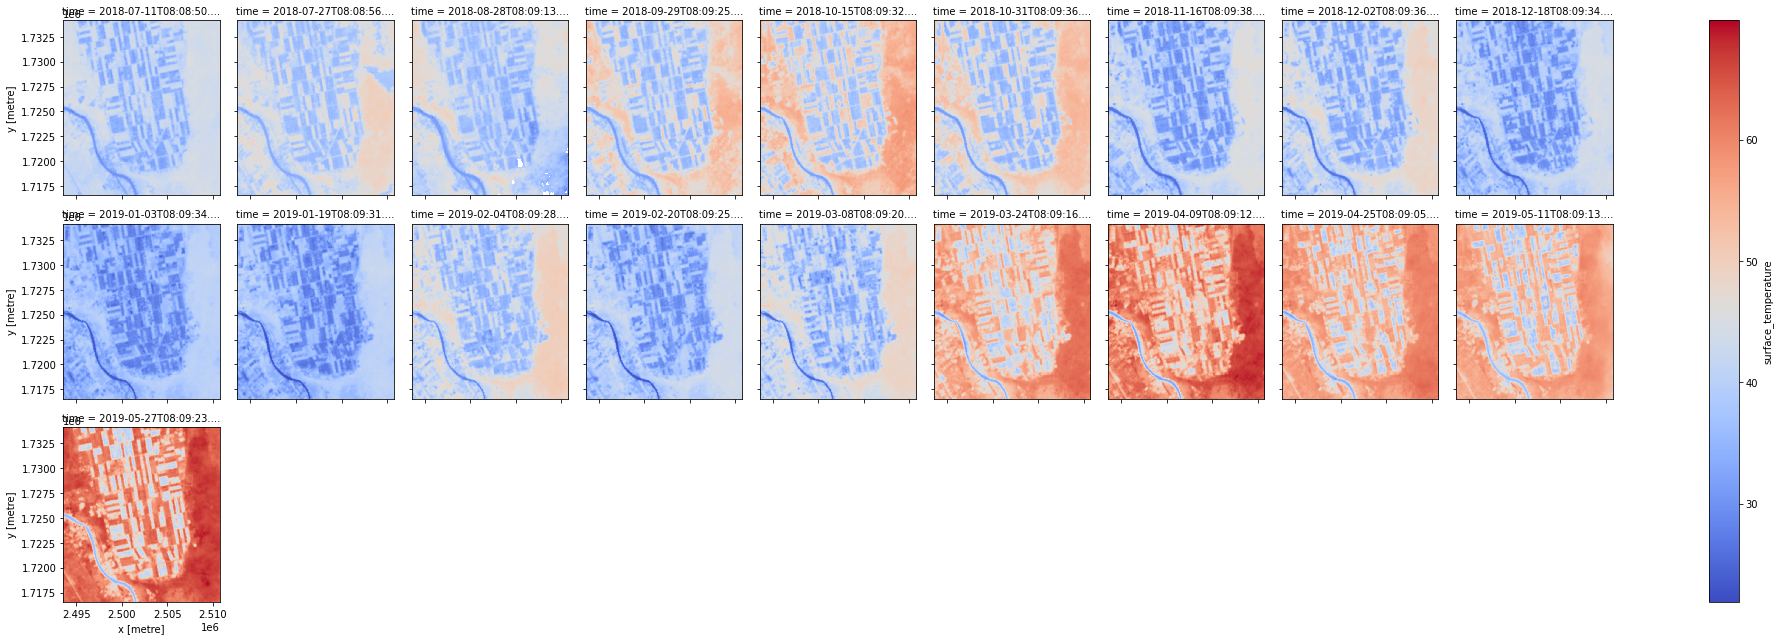

In [7]:
ds.surface_temperature.plot.imshow(col='time', col_wrap=9, cmap='coolwarm');

## Load ERA5 Air Temperature data

In [8]:
# load ERA5 air temperature at 2m height
var = 'air_temperature_at_2_metres'
air_temp = load_era5(var, lat_range, lon_range, time, reduce_func=np.mean)[var] - 273.15

### Inspect air and surface temperature data together

We can collapse both datasets over the latitude/longitude axes and plot by time to inspect the data for any anomalies or inconsistencies before proceeding.

In [9]:
ds_mean = ds.groupby('time').mean(dim=xr.ALL_DIMS)

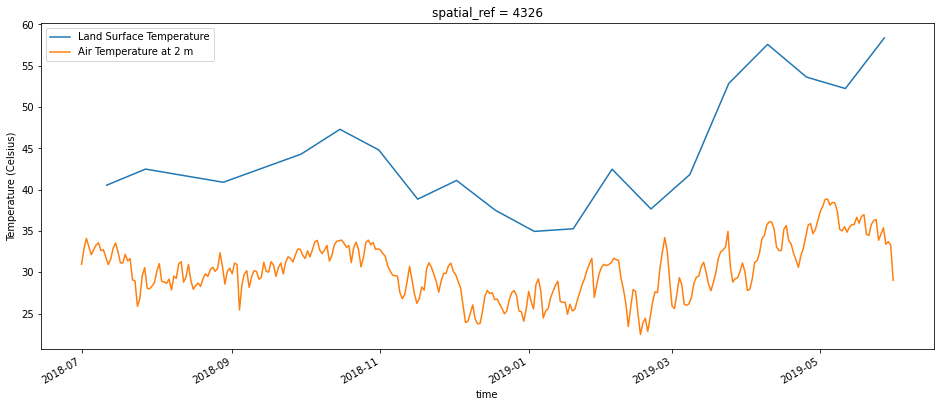

In [10]:
ds_mean.surface_temperature.plot(figsize = (16, 6),label='Land Surface Temperature');
air_temp.groupby('time').mean(dim=xr.ALL_DIMS).plot(label='Air Temperature at 2 m');
plt.ylabel('Temperature (Celsius)')
plt.legend()

The above plots show the data has loaded correctly. ERA5 temporal resolution is higher than Landsat 8, which accounts for the greater fluctuation. It is also expected that land temperature will be higher than 2 metre air temperature. 

Note the land temperature estimated by Landsat 8 can seem quite high; here, it is shown in excess of 40 degrees Celsius. In this notebook, we do not have the means to validate the dataset so it is difficult to tell if the readings are accurate, or exaggerated due to inherent instrumentation error. Regardless, this is mitigated by the CWSI calculation, which looks at the difference between temperatures instead of absolute values.

## Calculate CWSI

As noted in the introduction, for this exercise we estimate Crop Water Stress Index using the loaded temperature datasets in lieu of in-situ data. This can be broken down into the following steps:

1. Match timesteps between land temperature and air temperature
2. Find the difference $\Delta T$ between $T_c$ (land temperature) and $T_a$ (air temperature)
3. Find the minimum and maximum $\Delta T$ values to approximate for $\Delta T_{ul}$ and $\Delta T_{ll}$

This gives all necessary values to calculate CWSI.

In [11]:
# normalise datetime values (remove hour/min) so we can match them
air_temp['time'] = air_temp.indexes['time'].normalize()

ds['time'] = ds.indexes['time'].normalize()

In [12]:
# match times, compute air_temp (take out of chunks), and rename dims to match
air_temp_ds = air_temp.sel(time=ds.time)
air_temp_ds = air_temp_ds.compute()
air_temp_ds.rename({'lon': 'x','lat': 'y'});

In [13]:
air_temp_ds_reproj = xr_reproject(src=air_temp_ds,
                                  geobox=ds.geobox,
                                  resampling="bilinear")

Calculate $\Delta T$:

In [14]:
deltat = ds.surface_temperature - air_temp_ds_reproj

Minimum and maximum values of $\Delta T$:

In [15]:
ll = deltat.min(dim='time')
ul = deltat.max(dim='time')

### Define and calculate CWSI

In [16]:
cwsi = (deltat - ll)/(ul - ll)

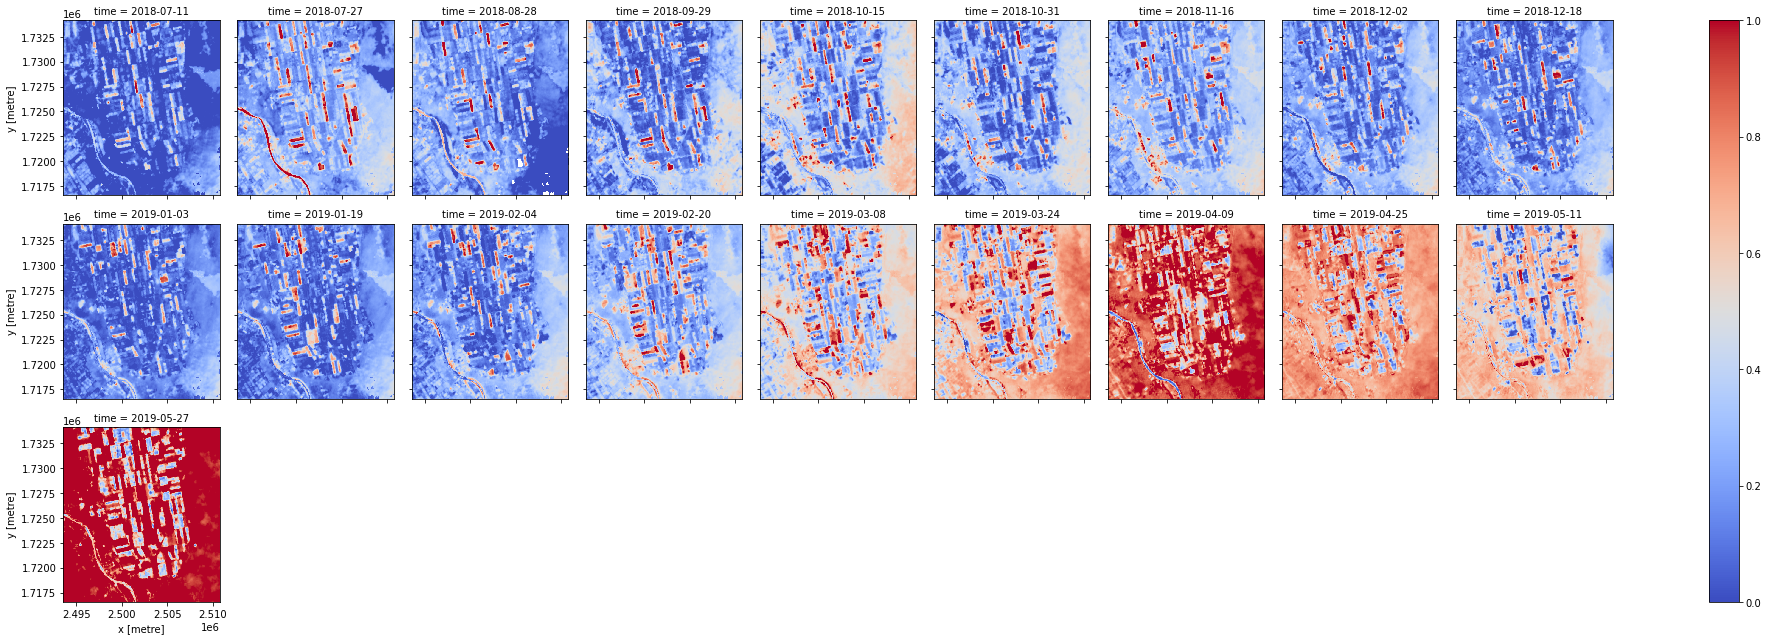

In [17]:
cwsi.plot.imshow(col='time', col_wrap=9, cmap='coolwarm');

## Interpretation

We can see here the irrigated cropping fields experience low crop water stress, even during the Egyptian summer months around the middle of the year. The area surrounding the circular fields - presumably non-cropping areas - show the contrast caused by irrigation. Over the colder season, crop water stress is lower as cooler temperatures reduce water loss and the need for plant transpiration. 

We can see how this relates to vegetation cover below. We use the same loading parameters as for surface temperature, but this time surface relfectance is loaded. As these are derived from the same sensor, Landsat-8, they will have matching overpass dates so will be comparable.

## Load Landsat-8 Surface Reflectance data

In [18]:
ds_sr = load_ard(dc=dc,
               products=['ls8_sr'],
               x=lon_range,
               y=lat_range,
               time=time,
               measurements =['red', 'green', 'blue', 'nir'],
               output_crs = 'EPSG:32633',
               resolution = (-30, 30),
               min_gooddata = 0.95)

ds_ndvi = calculate_indices(ds_sr, index='NDVI', collection = 'c2')

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 19 out of 20 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 19 time steps


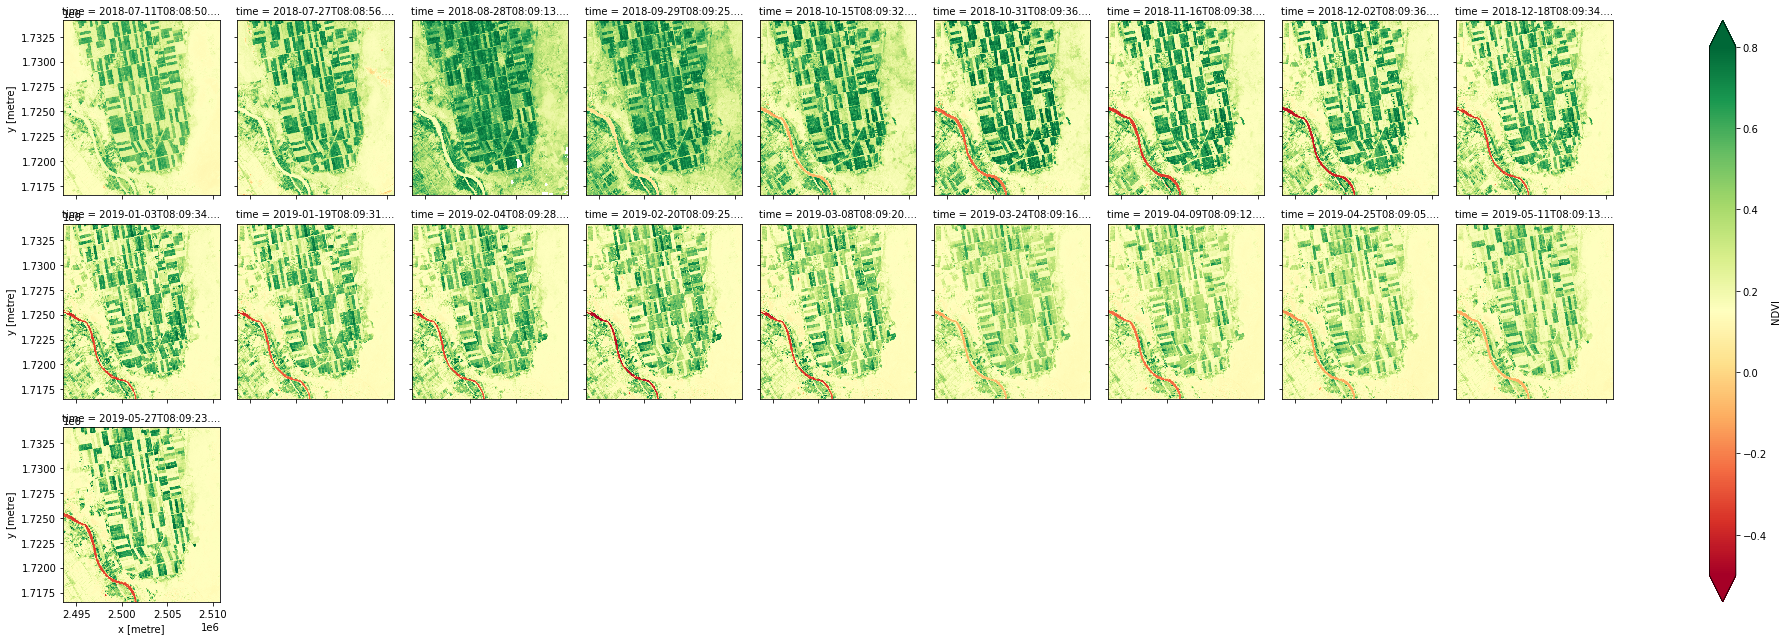

In [19]:
ds_ndvi.NDVI.plot(col='time', col_wrap = 9, vmin=-0.50, vmax=0.8, cmap='RdYlGn')

We can see that fields are mostly fallow (no crop is being grown) or there is non-green vegetation in the fields during October and November, which relate to some of the high CWSI values above.

# Further analysis with crop masking

We can assess how crop water stress varies with the phenology of the crops. But to do this, we will need to restrict our analysis to the irrigated fields and exclude other landscape features. We can use the crop mask for this.

**Important note**: The crop mask does not differentiate between irrigated and rainfed cropland. That's ok in this case because there is only irrigated cropland in our area of interest. However, this approach may not apply to other areas.

### Load crop mask

In [20]:
cm = dc.load(product='crop_mask_sahel',
             x=lon_range,
             y=lat_range,
             time=time,
             resolution = (-30, 30),
             output_crs= 'EPSG:32633')

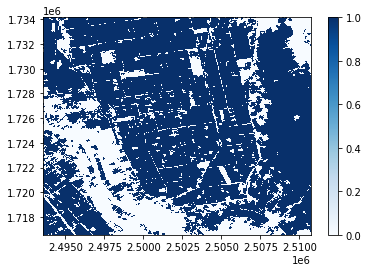

In [21]:
cm.filtered.plot(cmap='Blues', add_labels=False)

In [22]:
ds_ndvi

<xarray.Dataset>
Dimensions:      (time: 19, y: 586, x: 572)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-11T08:08:50.541894 ... 2019-05...
  * y            (y) float64 1.734e+06 1.734e+06 ... 1.717e+06 1.717e+06
  * x            (x) float64 2.494e+06 2.494e+06 ... 2.511e+06 2.511e+06
    spatial_ref  int32 32633
Data variables:
    red          (time, y, x) float32 0.2026 0.2036 0.2046 ... 0.2404 0.2313
    green        (time, y, x) float32 0.1581 0.1596 0.1602 ... 0.1799 0.1725
    blue         (time, y, x) float32 0.09937 0.1 0.1002 ... 0.1091 0.1086 0.104
    nir          (time, y, x) float32 0.2664 0.2687 0.2697 ... 0.3216 0.3121
    NDVI         (time, y, x) float32 0.136 0.1378 0.1371 ... 0.1445 0.1488
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

## Compare NDVI and CWSI within cropland

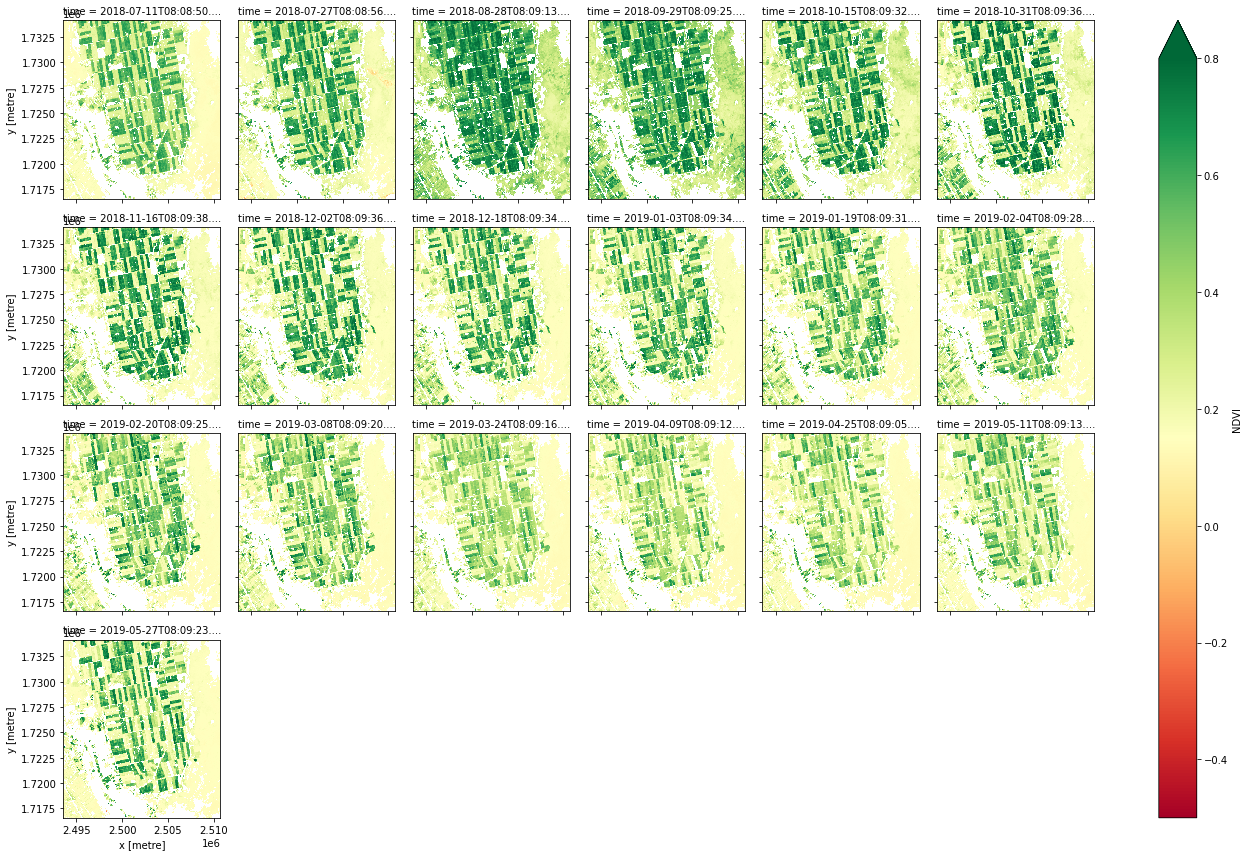

In [23]:
ds_ndvi['cwsi'] = (['time', 'y', 'x'],cwsi.values)
ds_ndvi_mask = ds_ndvi.where(cm.squeeze().filtered)
#cwsi_mask = cwsi.where(cm.squeeze().filtered)
ds_ndvi_mask.NDVI.plot(col='time', col_wrap=6, vmin=-0.50, vmax=0.8, cmap='RdYlGn');

In [24]:
ds_ndvi

<xarray.Dataset>
Dimensions:      (time: 19, y: 586, x: 572)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-11T08:08:50.541894 ... 2019-05...
  * y            (y) float64 1.734e+06 1.734e+06 ... 1.717e+06 1.717e+06
  * x            (x) float64 2.494e+06 2.494e+06 ... 2.511e+06 2.511e+06
    spatial_ref  int32 32633
Data variables:
    red          (time, y, x) float32 0.2026 0.2036 0.2046 ... 0.2404 0.2313
    green        (time, y, x) float32 0.1581 0.1596 0.1602 ... 0.1799 0.1725
    blue         (time, y, x) float32 0.09937 0.1 0.1002 ... 0.1091 0.1086 0.104
    nir          (time, y, x) float32 0.2664 0.2687 0.2697 ... 0.3216 0.3121
    NDVI         (time, y, x) float32 0.136 0.1378 0.1371 ... 0.1445 0.1488
    cwsi         (time, y, x) float32 0.1442 0.1384 0.1372 ... 1.0 1.0 1.0
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

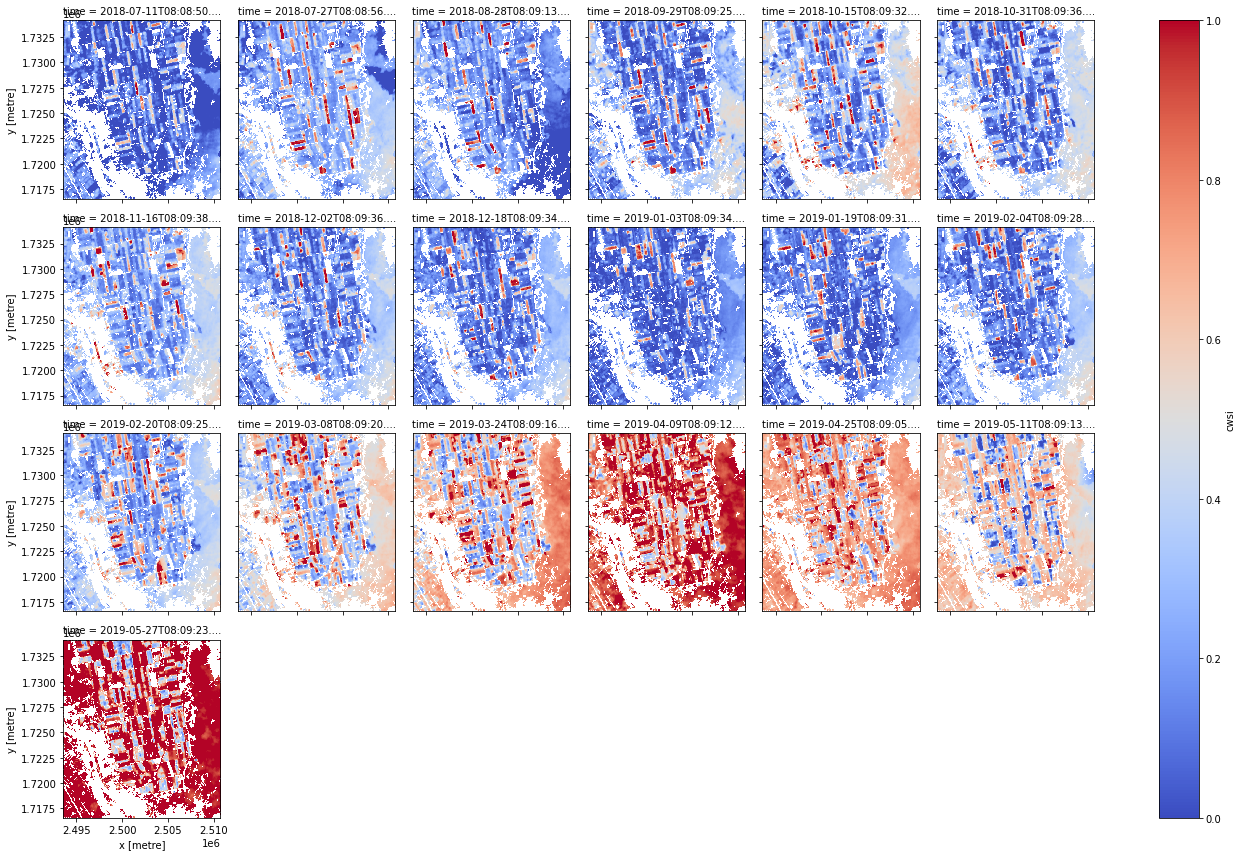

In [26]:
ds_ndvi_mask.cwsi.plot.imshow(col='time', col_wrap=6, cmap='coolwarm');

Threshold:  0.37541205


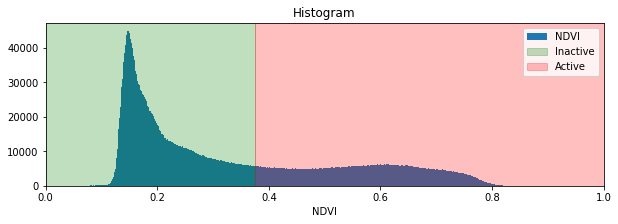

In [27]:
from skimage.filters import threshold_li

#find the threshold
threshold = threshold_li(ds_ndvi_mask.NDVI.values)
print("Threshold: ", threshold)

#plot a histogram of the result
fig, ax = plt.subplots(figsize=(10, 3))
ds_ndvi_mask.NDVI.plot.hist(bins=1000, label="NDVI")
plt.xlim(0,1)
ax.axvspan(xmin=0, xmax=threshold, alpha=0.25, color="green", label="Inactive"),
ax.axvspan(xmin=threshold,
           xmax=1,
           alpha=0.25,
           color="red",
           label="Active")
plt.legend();

We can also compute the correlation between CWSI and NDVI over speace and time. It is negative, which is intuitive as we would expect crop water stress to be higher when canopy greenness is lower. This is confirmed for the time dimension in the plot below.

In [28]:
xr.corr(ds_ndvi_mask.NDVI, ds_ndvi_mask.cwsi, dim=xr.ALL_DIMS)

<xarray.DataArray ()>
array(-0.43798005)
Coordinates:
    spatial_ref  int32 32633

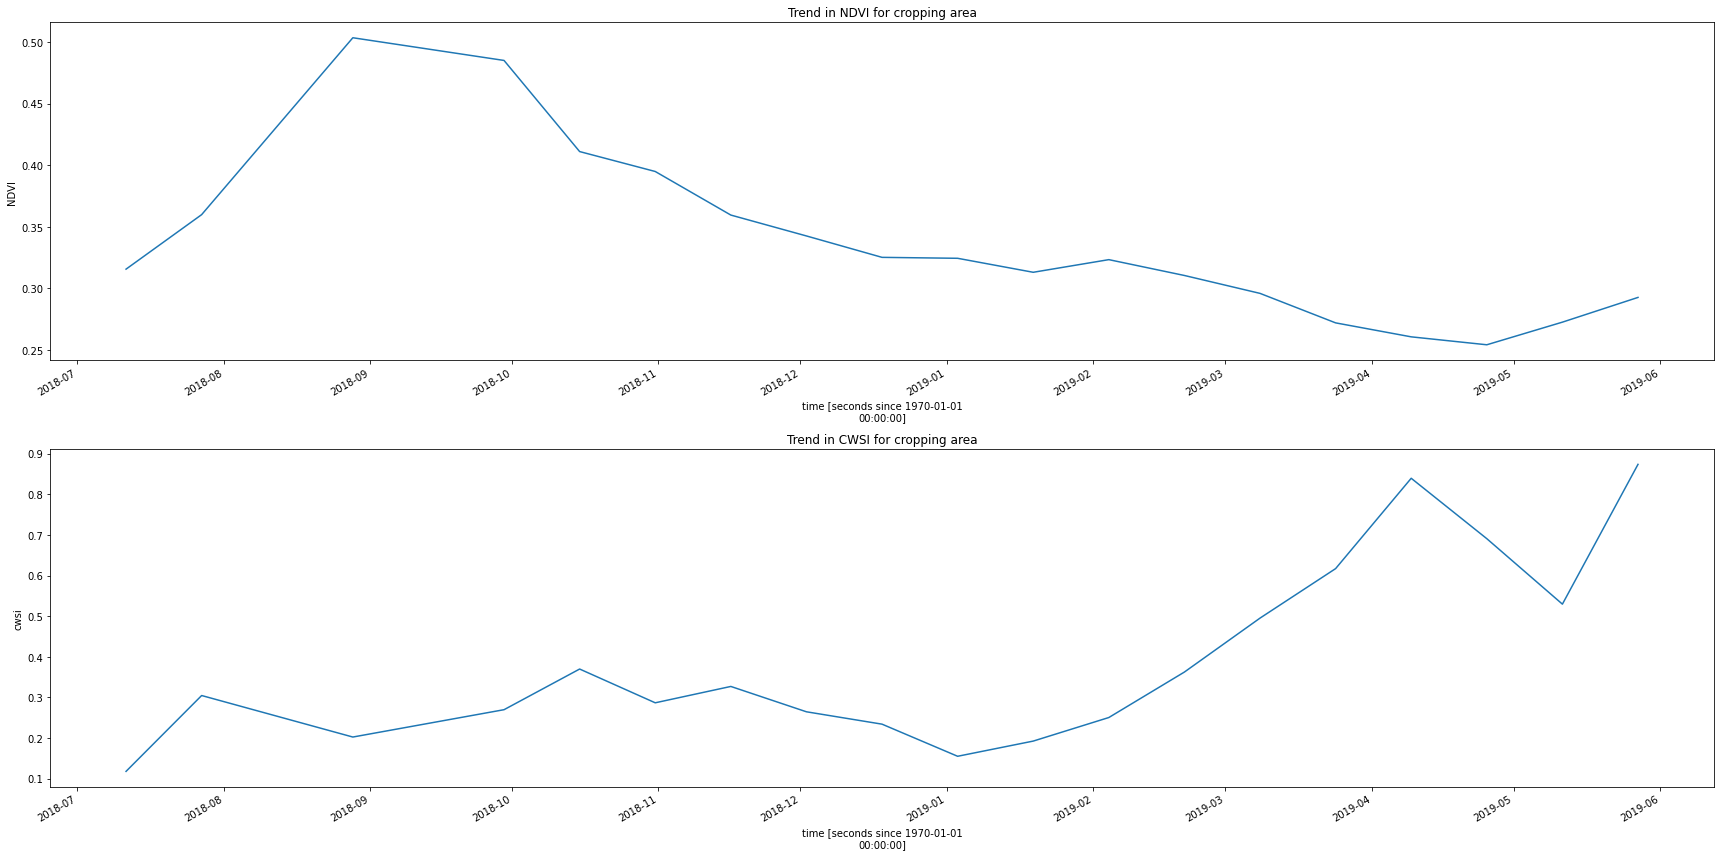

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(24, 12))
ds_ndvi_mask.NDVI.mean(['x', 'y']).plot(ax=axes[0])
ds_ndvi_mask.cwsi.mean(['x', 'y']).plot(ax=axes[1])
axes[0].set_title('Trend in NDVI for cropping area')
axes[1].set_title('Trend in CWSI for cropping area');

plt.tight_layout();

### Interpretation

In the plot above, we can see that within the crop fields, there is a lot of green vegetation around September 2018 and this corresponds with high crop water stress. Similarly for April and May 2019. There is a lot of green vegation in January 2019 but minimal crop water stress. 

## Limitations

This method of calculating CWSI is based on several key assumptions:

* Air temperature is reasonably approximated by ERA5
* Land temperature is reasonably approximated by Landsat 8 Surface Temperature
* The minimum value of the temperature difference reasonably approximates the lower limit
* The maximum value of the temperature difference reasonably approximates the upper limit

Local minima and maxima vary depending on the loaded datasets. This means this method is not necessarily robust to changes in:

* Location of area of interest
* Size of area of interest
* Time period
* Severe fluctuations in either temperature dataset
* Method of resampling

As always, results should be interpreted with context and care.

## Next steps

* Investigate different CWSI behaviour between rainfed and irrigated cropping areas, potentially using the DE Africa crop mask and CHIRPS rainfall data

## References

Jackson, Ray D., Kustas, William P., and Choudhury, Bhaskar J. 1988. 'A Reexamination of the Crop Water Stress Index'. *Irrig Sci* 9:309-317

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')